In [4]:
import os

PATH = "D:\\Documents\\GitHub\\medical-imaging-evaluation"
DATA_PATH = "D:\\Documents\\GitHub\\medical-imaging-evaluation\\data"
os.chdir(PATH)

In [5]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVR, SVC
from sklearn.cluster import DBSCAN
from sklearn.metrics import jaccard_score, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from model.metrics.metrics_wrapper import Metrics

sns.set()

In [6]:
train_eval = pd.read_csv(DATA_PATH + '/OpenPart.csv')
test_eval = pd.read_csv(DATA_PATH + '/SecretPart_dummy.csv')
train_eval.head()

,Case,Sample 1,Sample 2,Sample 3
0,00000072_000.png,1,5,1
1,00000150_002.png,5,5,3
2,00000181_061.png,4,4,3
3,00000211_019.png,4,4,2
4,00000211_041.png,3,5,2


In [36]:
train_names = train_eval['Case'].to_numpy()
test_names = test_eval['Case'].to_numpy()
val_indices = np.random.choice(train_names.shape[0], 20, replace=False)
train_indices = [i for i in range(len(train_names)) if i not in val_indices]
val_names = train_names[val_indices]
train_names = train_names[train_indices]
val_label = train_eval.iloc[val_indices]
train_label = train_eval.iloc[train_indices]
print('train size =', len(train_names))
print('validation size =', len(val_names))

train size = 40
validation size = 20


In [37]:
def load_data(names, folder, ending):
    data = []
    for name in names:
        image = cv2.imread(folder + '/' + name.split('.')[0] + ending + '.png', 0)
#         image = (image > 10).astype(np.int_)
        data.append(image)
    return np.array(data)

train_data = [
    load_data(train_names, DATA_PATH + '/sample_1', '_s1'),
    load_data(train_names, DATA_PATH + '/sample_2', '_s2'),
    load_data(train_names, DATA_PATH + '/sample_3', '_s3')
]
val_data = [
    load_data(val_names, DATA_PATH + '/sample_1', '_s1'),
    load_data(val_names, DATA_PATH + '/sample_2', '_s2'),
    load_data(val_names, DATA_PATH + '/sample_3', '_s3')
]
test_data = [
    load_data(test_names, DATA_PATH + '/sample_1', '_s1'),
    load_data(test_names, DATA_PATH + '/sample_2', '_s2'),
    load_data(test_names, DATA_PATH + '/sample_3', '_s3')
]
expert_train = load_data(train_names, DATA_PATH + '/expert', '_expert')
expert_val = load_data(val_names, DATA_PATH + '/expert', '_expert')
expert_test = load_data(test_names, DATA_PATH + '/expert', '_expert')

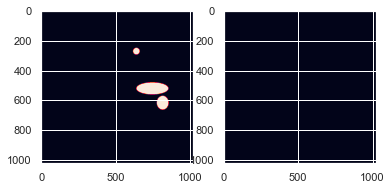

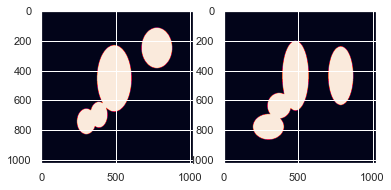

In [9]:
for i in range(2):
    plt.subplot(1, 2, 1)
    plt.imshow(test_data[0][i])
    plt.subplot(1, 2, 2)
    plt.imshow(expert_test[i])
    plt.show()

## Кластеризация (признана мало подходящим способом улучшения текущих данных)

In [221]:
def convert_to_table(img):
    elements = []
    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i][j] > 0:
                elements.append([i, j])
    return pd.DataFrame(elements)

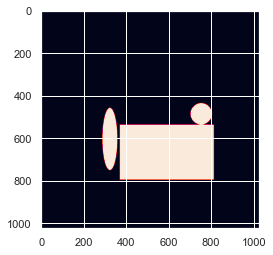

In [190]:
plt.imshow(expert_train[1])

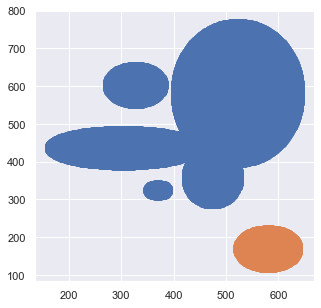

In [311]:
dbscan = DBSCAN(eps=40)
pred = dbscan.fit_predict(img_table)
plt.figure(figsize=(5,5))
for cl in np.unique(pred):
    cl_inds = [i for i in range(len(pred)) if pred[i] == cl]
    plt.scatter(img_table[0].iloc[cl_inds], img_table[1].iloc[cl_inds])
plt.show()

## Подсчёт метрик и построение модели

In [10]:
def compute_metrics(ex, pred):
    if ex.sum() == 0 and pred.sum() == 0:
        return [0] * 8
    elif ex.sum() == 0 or pred.sum() == 0:
        return []
    metrics = Metrics(ex, pred)
    result = []
    result.append(metrics.average_surface_distance())
    result.append(metrics.dice_coefficient())
    result.append(metrics.robust_hausdorff(0))
    result.append(metrics.robust_hausdorff(50))
    result.append(metrics.robust_hausdorff(100))
    result.append(metrics.surface_overlap_tolerance())
    result.append(metrics.dice_coefficient_tolerance())
    final = []
    for res in result:
        if type(res) == tuple:
            final.append(res[0])
            final.append(res[1])
        else:
            final.append(res)
    return final

def make_dataframe(expert, predicted):
    data = []
    for i in range(len(expert)):
        data.append(np.array(compute_metrics(expert[i], predicted[i])))
    return pd.DataFrame(data)

In [11]:
class RoundRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model, round_model=True):
        self.model = model
        self.round_model = round_model
        
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        pred = self.model.predict(X)
        if self.round_model:
            pred = np.round(pred, 0).astype(int)
        return pred

### Простейшая модель с одной метрикой

In [22]:
def make_dataframe_jaccard_score(expert, predicted):
    data = []
    for i in range(len(expert)):
        row = [jaccard_score((expert[i].reshape(1, -1)[0] > 0).astype(int),
                             (predicted[i].reshape(1, -1)[0] > 0).astype(int))]
        data.append(np.array(row))
    return pd.DataFrame(data)

base_df = pd.concat([
    make_dataframe_jaccard_score(expert_train, train_data[0]).fillna(-1),
    make_dataframe_jaccard_score(expert_train, train_data[1]).fillna(-1),
    make_dataframe_jaccard_score(expert_train, train_data[2]).fillna(-1)
])
labels = pd.concat([train_label['Sample 1'], train_label['Sample 2'], train_label['Sample 3']])

scaler = StandardScaler()
base_df = scaler.fit_transform(base_df)
models = [LinearRegression(), RandomForestRegressor(), RandomForestClassifier(), GradientBoostingClassifier(),
          KNeighborsRegressor(), KNeighborsClassifier(), SVC(), SVR(),
         GaussianNB(), LogisticRegression()]
skf = StratifiedKFold(n_splits=3)
for model in models:
    print(model, end=': ')
    rounded = cross_validate(estimator=RoundRegressor(model), X=base_df, y=labels,
                   scoring='neg_mean_absolute_error', cv=skf)['test_score']
    print(rounded.mean())

C:\ProgramData\Anaconda3\envs\pytorch-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LinearRegression(): -0.837037037037037
RandomForestRegressor(): -1.0296296296296295
RandomForestClassifier(): -0.9851851851851853
GradientBoostingClassifier(): -0.9851851851851853
KNeighborsRegressor(): -1.0296296296296295
KNeighborsClassifier(): -0.9777777777777779
SVC(): -0.8222222222222223
SVR(): -0.7703703703703703
GaussianNB(): -0.888888888888889
LogisticRegression(): -0.9037037037037038


### Большее количество метрик

In [77]:
def bootstrap(model, X, y, k=200):
    scores = []
    for i in range(k):
        inds = np.random.choice(X[0].shape[0], 10, replace=False)
        not_inds = [i for i in range(X[0].shape[0]) if i not in inds]
        
        train_df = np.concatenate([X[j][not_inds] for j in range(len(X))])
        test_df = np.concatenate([X[j][inds] for j in range(len(X))])
        
        scaler = StandardScaler()
        train_df = scaler.fit_transform(train_df)
        test_df = scaler.transform(test_df)
        
        train_labels = np.concatenate([np.array(y[j])[not_inds] for j in range(len(y))])
        test_labels = np.concatenate([np.array(y[j])[inds] for j in range(len(y))])
        
        model.fit(train_df, train_labels)
        scores.append(mean_absolute_error(model.predict(test_df), test_labels))
    return np.array(scores)

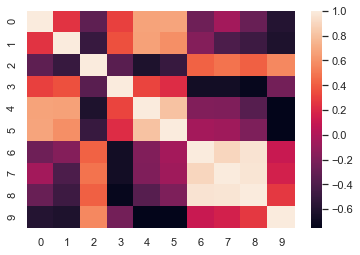

In [39]:
X = [
    make_dataframe(expert_train, train_data[0]),
    make_dataframe(expert_train, train_data[1]),
    make_dataframe(expert_train, train_data[2])
]

y = [
    train_label['Sample 1'],
    train_label['Sample 2'],
    train_label['Sample 3']
]

X_df = pd.concat(X)
X_df['label'] = np.concatenate(y)
X_df = StandardScaler().fit_transform(X_df)
sns.heatmap(pd.DataFrame(X_df).corr(method="spearman"))

for i in range(len(X)):
    X[i] = X[i].fillna(-1).to_numpy()
#     X[i] = scaler.transform(X[i])

In [40]:
train_df = np.concatenate(X)
val_df = pd.concat([
    make_dataframe(expert_val, val_data[0]),
    make_dataframe(expert_val, val_data[1]),
    make_dataframe(expert_val, val_data[2])
]).fillna(-1).to_numpy()

scaler = StandardScaler()
train_df = scaler.fit_transform(train_df)
val_df = scaler.transform(val_df)

train_labels = np.concatenate(y)
val_labels = np.concatenate([
    val_label['Sample 1'],
    val_label['Sample 2'],
    val_label['Sample 3']
])

In [76]:
models = [
    LinearRegression(),
    LogisticRegression(),
    RandomForestRegressor(random_state=0),
    RandomForestRegressor(random_state=0, criterion='mae'),
    RandomForestClassifier(random_state=0),
    GradientBoostingClassifier(),
    KNeighborsRegressor(),
    KNeighborsClassifier(),
    SVC(),
    SVR(),
    GaussianNB()
]

means = []
stds = []
scores = []
for model in models:
    print(model, end=': ')
    rounded = bootstrap(RoundRegressor(model), X, y)
    scores.append(rounded)
    means.append(rounded.mean())
    print(means[-1])
    stds.append(rounded.std())

LinearRegression(): 0.6362666666666666
LogisticRegression(): 0.5927333333333333
RandomForestRegressor(random_state=0): 0.6188666666666667
RandomForestRegressor(criterion='mae', random_state=0): 0.5552
RandomForestClassifier(random_state=0): 0.5702
GradientBoostingClassifier(): 0.6247999999999999
KNeighborsRegressor(): 0.7022
KNeighborsClassifier(): 0.6827333333333333
SVC(): 0.6116666666666665
SVR(): 0.5791333333333333
GaussianNB(): 0.6457999999999999


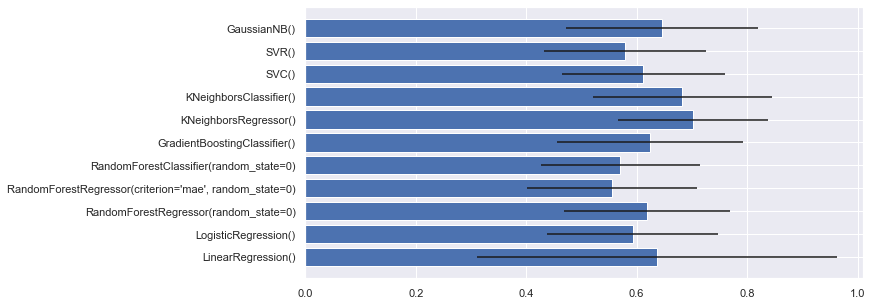

In [78]:
plt.figure(figsize=(10, 5))
plt.barh([str(i) for i in models], means, xerr=stds)
plt.show()

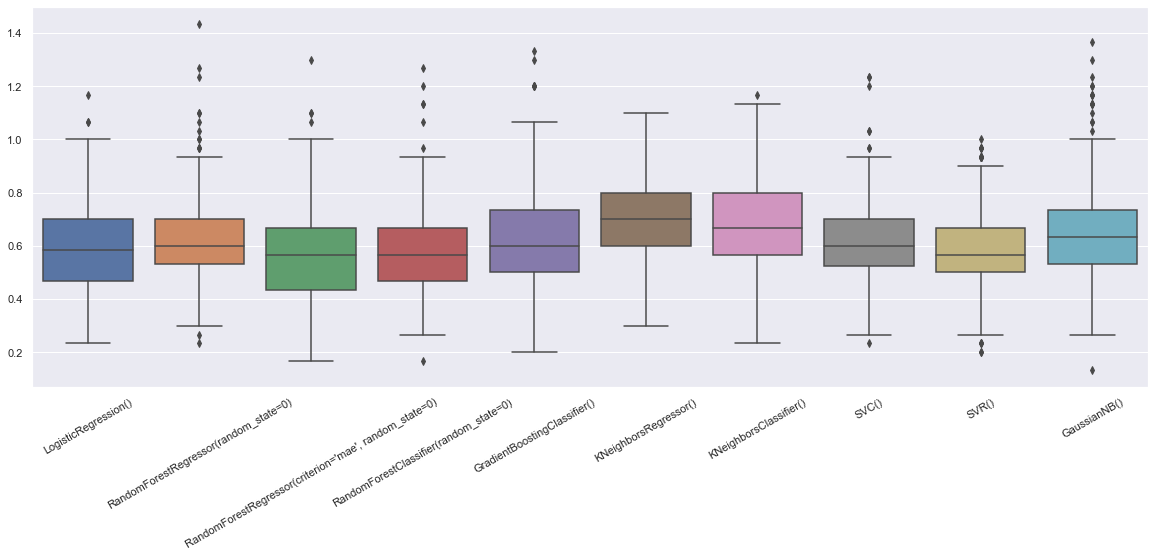

In [81]:
plt.figure(figsize=(20, 7))
ax = sns.boxplot(data=pd.DataFrame(scores[1:], [str(i) for i in models[1:]]).T)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.show()

In [82]:
model = RoundRegressor(RandomForestRegressor(random_state=0, criterion='mae')).fit(train_df, train_labels)
mean_absolute_error(model.predict(val_df), val_labels)

0.4666666666666667

In [83]:
model = RandomForestClassifier().fit(train_df, train_labels)
mean_absolute_error(model.predict(val_df), val_labels)

0.5166666666666667

### Отбор метрик (провалил тесты)

In [47]:
for th in [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]:
    model = SelectFromModel(RandomForestRegressor(random_state=0, criterion='mae'), threshold=th).fit(train_df, train_labels)
    print([i for i in range(9) if model.get_support()[i]])

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 1, 2, 4, 5]
[2, 4, 5]
[2, 5]
[2]


In [48]:
bt = bootstrap(RoundRegressor(RandomForestRegressor(random_state=0, criterion='mae')), [x[:,[0, 1, 2, 4, 5]] for x in X], y)
bt.mean(), bt.std()

(0.5516666666666665, 0.15307042678308425)

### Ограничим максимальную глубину дерева, добавим больше деревьев

In [49]:
models = [
    RandomForestRegressor(random_state=0, criterion='mae'),
    RandomForestRegressor(random_state=0, criterion='mae', max_depth=5),
    RandomForestRegressor(random_state=0, criterion='mae', max_depth=10),
    RandomForestRegressor(random_state=0, criterion='mae', max_depth=15),
    RandomForestRegressor(random_state=0, criterion='mae', max_depth=20),
    RandomForestRegressor(random_state=0, criterion='mae', max_depth=30)
]

means = []
stds = []
for model in models:
    print(model, end=': ')
    rounded = bootstrap(RoundRegressor(model), X, y)
    means.append(rounded.mean())
    print(means[-1])
    stds.append(rounded.std())

RandomForestRegressor(criterion='mae', random_state=0): 0.5509999999999999
RandomForestRegressor(criterion='mae', max_depth=5, random_state=0): 0.5273333333333333
RandomForestRegressor(criterion='mae', max_depth=10, random_state=0): 0.5303333333333333
RandomForestRegressor(criterion='mae', max_depth=15, random_state=0): 0.552
RandomForestRegressor(criterion='mae', max_depth=20, random_state=0): 0.5776666666666667
RandomForestRegressor(criterion='mae', max_depth=30, random_state=0): 0.5576666666666665


In [51]:
model = RoundRegressor(RandomForestRegressor(random_state=0, criterion='mae', max_depth=5,
                                            n_estimators=500)).fit(train_df, train_labels)
mean_absolute_error(model.predict(val_df), val_labels)

0.4666666666666667

### Аугментация данных

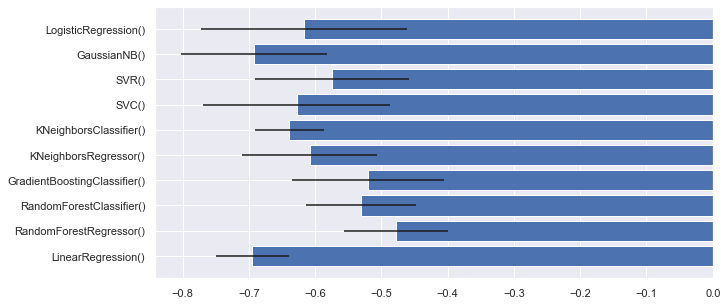

In [141]:
plt.figure(figsize=(10, 5))
plt.barh([str(i) for i in models], means, xerr=stds)
plt.show()